In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [53]:
#!pip install tweepy --upgrade
#!pip install seaborn
#!pip install pycountry
#!pip install wordcloud
#!pip install sklearn
#!pip install numpy
#!pip install scipy
#!pip install tensorflow==2.4.1
#References https://towardsdatascience.com/a-step-by-step-tutorial-for-conducting-sentiment-analysis-a7190a444366
#           https://deeplizard.com/learn/video/km7pxKy4UHU
#           https://towardsdatascience.com/sentiment-analysis-on-the-tweets-about-distance-learning-with-textblob-cc73702b48bc

  Using cached typing_extensions-3.7.4.3-py3-none-any.whl (22 kB)
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.33.2
    Uninstalling grpcio-1.33.2:
      Successfully uninstalled grpcio-1.33.2
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.3.1
    Uninstalling tensorflow-2.3.1:
      Successfully uninstalled tensorflow-2.3.1


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'C:\\Users\\nigel\\AppData\\Roaming\\Python\\Python38\\site-packages\\~ensorflow\\lite\\experimental\\microfrontend\\python\\ops\\_audio_microfrontend_op.so'
Consider using the `--user` option or check the permissions.



In [1]:
import numpy as np
import pandas as pd, tweepy
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import pycountry
import pickle
import requests 
import warnings
import random
import itertools
from time import time

# Import nltk and download punkt, wordnet
import nltk

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Import word_tokenize and stopwords from nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer 
# Gensim
from gensim.models import Word2Vec

# Import the TextBlob
from textblob import TextBlob

# Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

# Import wordcloud
from wordcloud import WordCloud


%matplotlib inline
%config IPCompleter.greedy=True
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nigel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nigel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nigel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#Twitter Data Cleaning

In [ ]:
# Load the tweets
tweets_raw = pd.read_csv("csv_months_seperate_2020/sorted_raw_2020.csv")
display(tweets_raw.head())
print(tweets_raw.describe())
print(tweets_raw.info())

In [ ]:
tweets_raw.drop_duplicates(inplace=True)
tweets_raw['Created At'] = pd.to_datetime(tweets_raw['Created At'])
print(tweets_raw.info())

In [ ]:

def process_tweets(tweet):
    
    # Remove links
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    
    # Remove mentions and hashtag
    tweet = re.sub(r'\@\w+|\#','', tweet)
    
    # Tokenize the words
    tokenized = word_tokenize(tweet)

    # Remove the stop words
    tokenized = [token for token in tokenized if token not in stopwords.words("english")] 

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    tokenized = [lemmatizer.lemmatize(token, pos='a') for token in tokenized]

    # Remove non-alphabetic characters and keep the words contains three or more letters
    tokenized = [token for token in tokenized if token.isalpha() and len(token)>2]
    
    return tokenized
    
# Call the function and store the result into a new column
tweets_raw["Processed"] = tweets_raw["Content"].str.lower().apply(process_tweets)

# Print the first fifteen rows of Processed
display(tweets_raw[["Processed"]].head(15))

In [ ]:
# Get the tweet lengths
tweets_raw["Length"] = tweets_raw["Content"].str.len()
tweets_raw["Words"] = tweets_raw["Content"].str.split().str.len()
display(tweets_raw[["Length", "Words"]])

In [ ]:
# Fill the missing values with unknown tag
tweets_raw["Location"].fillna("unknown", inplace=True)

In [ ]:
def get_countries(location):
    
    # If location is a country name return its alpha2 code
    if pycountry.countries.get(name= location):
        return pycountry.countries.get(name = location).alpha_2
    
    # If location is a subdivisions name return the countries alpha2 code
    try:
        pycountry.subdivisions.lookup(location)
        return pycountry.subdivisions.lookup(location).country_code
    except:
        # If the location is neither country nor subdivision return the "unknown" tag
        return "unknown"

# Call the function and store the country codes in the Country column
tweets_raw["Country"] = tweets_raw["Location"].apply(get_countries)

# Print the unique values
print(tweets_raw["Country"].unique())

# Print the number of unique values
print("Number of unique values:",len(tweets_raw["Country"].unique()))

In [ ]:
# Save the processed data as a csv file
tweets_raw.to_csv("csv_months_seperate_2020/tweets_processed_2020.csv")

#Twitter Sentiment Analysis

In [16]:
tweets_processed = pd.read_csv("02_Brexit_Tweets_19_20/New.csv", parse_dates=["Created At"])

In [17]:
#TfidfVectorizer - Transforms text to feature vectors that can be used as input to estimator
# Create our contextual stop words
tfidf_stops = ["amp","boris","brexit","vaccine","economic","political","A","About","Actually","Almost","Also","Although","Always","Am","An","And","Any","Are","As","At","Be","Became","Become","But","By","Can","Could","Did","Do","Does","Each","Either","Else","For","From","Had","Has","Have","Hence","How","If","In","IS","I","ITS","JUST","MAY","MAYBE","Me","Might","Mine","Must","My","Mine","Must","My","Neither","Nor","Not","Of","Oh","Ok","When","Where","Whereas","Wherever","","Whenever","Whether","Which","While","Who","Whom","Whoever","Whose","Why","Will","With","Within","Without","Would","Yes","Yet","You","Your","deal","may","vote","people","peoplesvote","would","theresa","get","one","time","mps","labour","parliament","referendum","voted","want"]
# Initialize a Tf-idf Vectorizer
vectorizer = TfidfVectorizer(max_features=1000, stop_words= tfidf_stops)

# Fit and transform the vectorizer
tfidf_matrix = vectorizer.fit_transform(tweets_processed["Processed"])

display(tfidf_matrix)

# Create a DataFrame for tf-idf vectors and display the first five rows
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns= vectorizer.get_feature_names())
display(tfidf_df.max())

C:\Users\nigel\anaconda3\envs\jupyterlab\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['about', 'actually', 'almost', 'also', 'although', 'always', 'am', 'an', 'and', 'any', 'are', 'as', 'at', 'be', 'became', 'become', 'but', 'by', 'can', 'could', 'did', 'do', 'does', 'each', 'either', 'else', 'for', 'from', 'had', 'has', 'have', 'hence', 'how', 'if', 'in', 'is', 'its', 'just', 'maybe', 'me', 'might', 'mine', 'must', 'my', 'neither', 'nor', 'not', 'of', 'oh', 'ok', 'when', 'whenever', 'where', 'whereas', 'wherever', 'whether', 'which', 'while', 'who', 'whoever', 'whom', 'whose', 'why', 'will', 'with', 'within', 'without', 'yes', 'yet', 'you', 'your'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


<2575950x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 18852345 stored elements in Compressed Sparse Row format>

able          1.0
absolute      1.0
absolutely    1.0
accept        1.0
access        1.0
             ... 
years         1.0
yes           1.0
yesterday     1.0
yet           1.0
young         1.0
Length: 1000, dtype: float64

In [6]:
#tweets_processed = pd.read_csv("02_Brexit_Tweets_19_20/tweets_sentiments.csv", parse_dates=["Created At"])

In [18]:
tfidf_matrix = vectorizer.fit_transform(tweets_processed["Processed"])

In [19]:
print("Since:",tweets_processed["Created At"].min())

print("Until",tweets_processed["Created At"].max())

Since: 2019-01-01 00:00:00
Until 2020-12-30 23:59:51


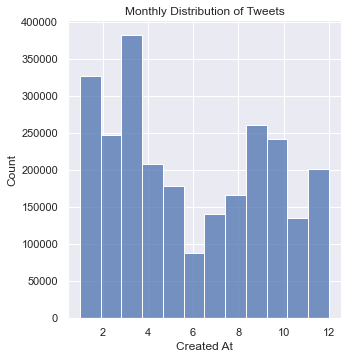

In [20]:
sns.set()
sns.displot(tweets_processed["Created At"].dt.month, bins=12)
plt.title("Monthly Distribution of Tweets")
plt.show()

In [21]:
# Print the value counts of Country column
print(tweets_processed["Country"].value_counts())

unknown    2277874
GB          195333
IE           23278
FR            9568
DE            9225
            ...   
VI               1
NE               1
KI               1
MS               1
TV               1
Name: Country, Length: 199, dtype: int64


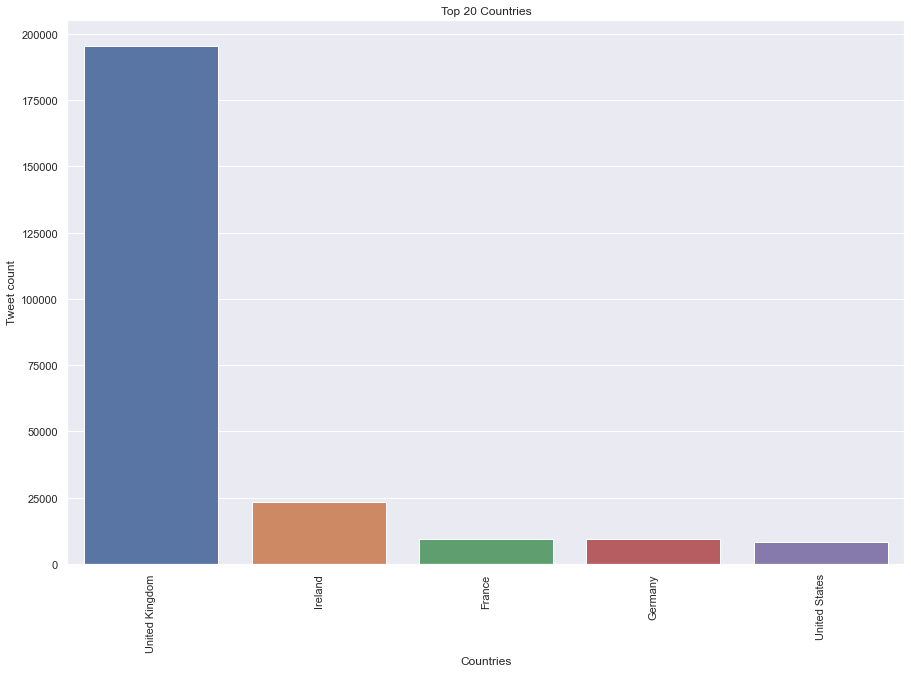

In [22]:
#exclude unknowns
countries = tweets_processed[tweets_processed.Country!='unknown']

# Select the top 20 countries
top_countries = countries["Country"].value_counts(sort=True).head(5)

# Convert alpha2 country codes to country names and store in a list
country_fullnames = []
for alpha2 in top_countries.index:
    country_fullnames.append(pycountry.countries.get(alpha_2=alpha2).name)

# Visualize the top 20 countries
plt.figure(figsize=(15,10))
sns.barplot(x=country_fullnames,y=top_countries)
plt.xlabel("Countries")
plt.ylabel("Tweet count")
plt.title("Top 20 Countries")
plt.xticks(rotation=90)
plt.show()

In [23]:
# Display the most popular tweets
display(tweets_processed.sort_values(by=["Favorites","Retweet-Count", ], axis=0, ascending=False)[["Content","Retweet-Count","Favorites"]].head(20))

,Content,Retweet-Count,Favorites
296696,"I've been wondering what that special place in hell looks like, for those who promoted #Brexit, without even a sketch of a plan how to carry it out safely.",23764.0,86700.0
1102056,EU election results as of right now:\n\nNigel Farage leading in England\nMarine Le Pen leading in France\nSalvini leading in Italy\n\nA global mass awakening is happening and there is nothing that the global elites or their media henchmen can do to stop it. \n\n#BREXIT #MAGA,17492.0,52374.0
785540,"I voted Remain.\nBut if there's a 2nd Referendum before we even try to honour the result of the 1st, then I will vote Leave purely as a protest against this ongoing attempt to defy &amp; destroy British democracy.\nI suspect I'm not alone. #Brexit",8556.0,48757.0
770433,You guys ruled half the world?\nReally? \nUnbelievable. \n#Brexit,8516.0,43585.0
1363060,"I have no idea which genius made it, but it was worth the creation of Monty Python for this alone. It?s perfect. \n#BorisJohnson #JeremyCorbyn #Brexit #BrexitShambles #SundayThoughts #SundayMotivation #SundayMorning \n\n https://t.co/XlsFL64qr2",17557.0,41539.0
735679,"BREAKING: Parliament just voted against every single form of Brexit. What a bunch of useless f*cking clowns. Where is someone, anyone, with the balls to lead us out of this endless nonsense? #brexit",5695.0,33450.0
673276,"Good luck to everyone on the Losers? march today, and to everyone signing the Losers? petition. I lost too, but somehow I found the strength to get over it, thus avoiding making a pointless whiny ?BUT MY OPINION IS MORE OPINION THAN DEMOCRACY!!? arse of myself. #Brexit",6199.0,32086.0
1619919,"I've never known a worse Parliament than this. \nA ludicrous, howling, self-absorbed bunch of shockingly mediocre charlatans - most of whom doing whatever they can to stop democracy happening. Shameful. #brexit",5137.0,30837.0
763059,Voting for a deal you know will damage the country simply so you get another shot at becoming Prime Minister. Hard to think of a less principled stance on the #Brexit chaos you helped create. You are an utterly shameless charlatan who is unfit to hold office. https://t.co/8XERFHSi2l,6710.0,28177.0
1660321,"Today I had two phone calls on #Brexit, first with Dublin then with London.\nMy message to Taoiseach @LeoVaradkar: We stand fully behind Ireland.\nMy message to PM @BorisJohnson: We remain open but still unconvinced.",7201.0,27941.0


In [24]:
frequencies = pd.DataFrame(tfidf_matrix.sum(axis=0).T,index=vectorizer.get_feature_names(),columns=['total frequency'])
# Display the most 20 frequent words
display(frequencies.sort_values(by='total frequency',ascending=False).head(20))

,total frequency
good,45722.838624
new,36836.986639
like,36676.371612
leave,34434.688015
right,29256.251991
party,27947.531762
country,27857.263426
remain,27560.877947
think,27414.568490
government,26828.243089


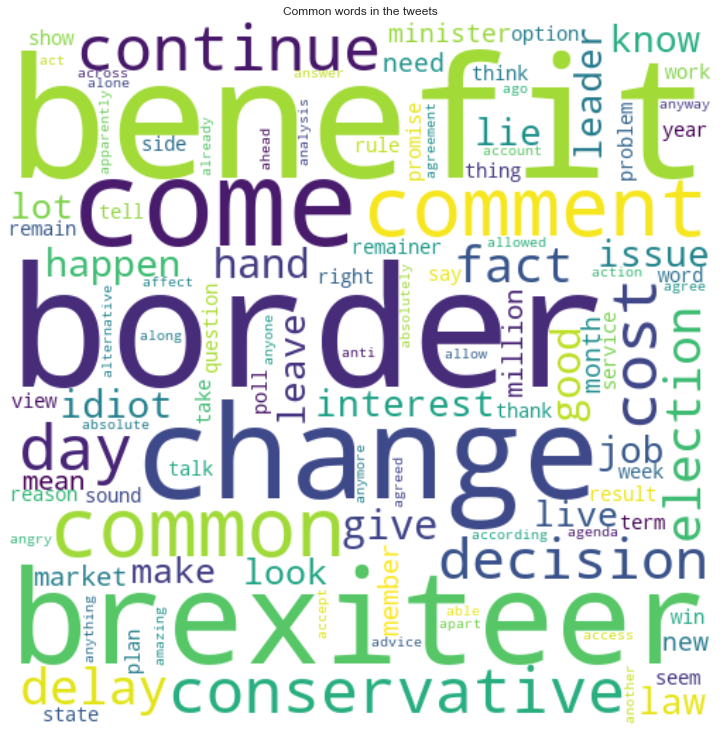

In [25]:
# Join the indexes
frequent_words = " ".join(frequencies.index)+" "

# Initialize the word cloud
wc = WordCloud(width = 500, height = 500, min_font_size = 10, max_words=2000, background_color ='white', stopwords= tfidf_stops)

# Generate the world clouds for each type of label
tweets_wc = wc.generate(frequent_words)

# Plot the world cloud                     
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(tweets_wc, interpolation="bilinear") 
plt.axis("off") 
plt.title("Common words in the tweets")
plt.tight_layout(pad = 0) 
plt.show()

In [ ]:
'''
TextBlob returns polarity and subjectivity of a sentence. Polarity lies between [-1,1], -1 defines a negative sentiment and 1 defines a positive sentiment.
'''
# Add polarities and subjectivities into the DataFrame by using TextBlob
tweets_processed["Polarity"] = tweets_processed["Processed"].apply(lambda word: TextBlob(word).sentiment.polarity)
tweets_processed["Subjectivity"] = tweets_processed["Processed"].apply(lambda word: TextBlob(word).sentiment.subjectivity)

display(tweets_processed[["Polarity","Subjectivity"]].head(10))

In [26]:
# classify polarities
def analyse_polarity(polarity):
    if polarity > 0:
        return "Positive"
    if polarity < 0:
        return "Negative"

# Apply the funtion on Polarity column and add the results into a new column
tweets_processed["Label"] = tweets_processed["Polarity"].apply(analyse_polarity)

# Display the Polarity and Subjectivity Analysis
display(tweets_processed[["Label"]].head(10))

,Label
0,Positive
1,Positive
2,Positive
3,Positive
4,Positive
5,Positive
6,Positive
7,Negative
8,Positive
9,Positive


In [27]:
# Print the value counts of the Label column
print(tweets_processed["Label"].value_counts())

Positive    1594878
Negative     981072
Name: Label, dtype: int64


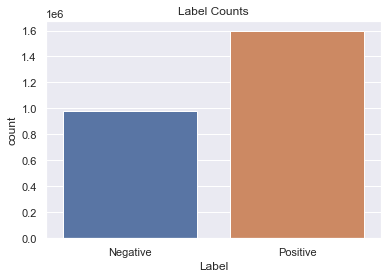

'\n# visualise the Polarity scores\nplt.figure(figsize = (50, 50)) \nsns.scatterplot(x="Polarity", y="Subjectivity", hue="Label", data=tweets_processed)\nplt.title("Subjectivity vs Polarity")\nplt.show()\n'

In [29]:
# Change the datatype as "category"
tweets_processed["Label"] = tweets_processed["Label"].astype("category")

# visualise the Label counts
sns.countplot(tweets_processed["Label"])
plt.title("Label Counts")
plt.show()
'''
# visualise the Polarity scores
plt.figure(figsize = (50, 50)) 
sns.scatterplot(x="Polarity", y="Subjectivity", hue="Label", data=tweets_processed)
plt.title("Subjectivity vs Polarity")
plt.show()
'''


In [44]:
tweets_processed.loc[tweets_processed.Label == 'Negative', 'Label'].count()

981072

In [30]:
# Display the positive tweets
display(tweets_processed.sort_values(by=["Polarity","Favorites","Retweet-Count", ], axis=0, ascending=[False, False, False])[["Content","Retweet-Count","Favorites","Polarity"]].head(20))

# Display the negative tweets
display(tweets_processed.sort_values(by=["Polarity", "Favorites", "Retweet-Count"], axis=0, ascending=[True, False, False])[["Content","Retweet-Count","Favorites","Polarity"]].head(20))

,Content,Retweet-Count,Favorites,Polarity
1960727,"Oh my gosh! I have wonderful news. \n\nThe UK had an election today &amp; exit polls show Conservatives taking 368 seats. \n\nLandslide, landslide, landslide! \n#Brexit",3816.0,13590.0,1.0
1402199,Excellent meeting between all the opposition party leaders this morning. We agree we will work together to stop a no deal #Brexit by legislation,1542.0,9170.0,1.0
1450260,?Brexit sends everybody nuts.?\n\n@piersmorgan does his best impression of Konnie Huq?s #Brexit rant. ?? https://t.co/shRlQ6DVpP,1657.0,8008.0,1.0
2072832,and the prize for the best #Brexit analogy goes to https://t.co/FsfDV4hNjI,1335.0,5026.0,1.0
1390319,Lord Heseltine - The best deal of all is to abandon #brexit. ??\n\n#bbcaq #PeoplesVote #RejectBrexit @BorisJohnson https://t.co/DWSpzsfn11,1717.0,4996.0,1.0
2298914,Perfect ??\n\n#Brexit #BeforeAndAfter https://t.co/lgvTWZRy4G,1231.0,4360.0,1.0
165243,Possibly the best thing my Mother has ever sent me... ever!\n#theresamay #brexit #niceonemum https://t.co/70E6PBMcaw,1585.0,4225.0,1.0
1519141,"The treatment of #RingoStarr is shameful, un-British. They say he doesn?t pay taxes here. Neither do Richard Branson, George Soros, Goldman Sachs JP Morgan or Barack Obama! For years the Beatles were one of our best exports. Show some respect,for him, for free-speech #Brexit",1114.0,3985.0,1.0
1618305,Bone: PM is wonderful and trustworthy. Anyone who suggests he lied. Is out of order\nKay: He was sacked for lying by the Telegraph ??\n#Brexit https://t.co/iVdwSotde2,1415.0,3710.0,1.0
421702,"""We are sleepwalking into a no deal scenario. It's unacceptable and your best friends have to warn you. Wake up""\n\nDutch PM Mark Rutte sends a message to UK PM Theresa May about #Brexit\n\n[tap to expand] https://t.co/EvfYi5UC5w https://t.co/lNsEjGqH9G",1746.0,3544.0,1.0


,Content,Retweet-Count,Favorites,Polarity
2234084,Remember #MichaelGove on how terrible the #Brexit #dominiccummimgs would be &gt;&gt; check this one https://t.co/68iRQTbsT1 https://t.co/XCZwOfhoTd,2162.0,2891.0,-1.0
865624,RT to tell the @Conservatives that you don't care about the 'consequences' to their party. You care about the devastating consequences of #Brexit to our country! https://t.co/JOsQiXFVct,2584.0,1800.0,-1.0
493758,"J Hunt is reported on @BBCRadio4 as saying stopping #brexit would be devastating for the Tory party. \nRead that again.\nFor the Tory party.\n\nNot even pretending the national interest, voters or even our neighbours, matter. It?s what it?s always been about: the Tory party.\nJeeesh",801.0,1775.0,-1.0
1460742,"Dominic Grieve - This motion should be passed so that the evils of a #NoDealBrexit are avoided, because I believe passionately that evil will follow...\n\n#HouseOfCommons #ResistanceBill #Brexit https://t.co/JeiVZx70cw",627.0,1740.0,-1.0
2006219,"We saw a fightback against federalist totalitarians like you, @guyverhofstadt. There is nothing liberal or democratic about the #EU, as your petulant response to #Brexit has shown. Soon other countries will get out of your clutches and your evil empire will crumble to dust. https://t.co/JbvmVurRb9",438.0,1535.0,-1.0
1365423,"#Brexit ""news"" on @SkyNews: Labour MP said they'll be no jobs. Association rep said they'll be no food or medicine. Travelling violinist said they'll be no music.\n\nWho else is getting fed up with this unrelentingly hysterical and unchallenged anti-Brexit bollocks?",358.0,1167.0,-1.0
1837950,"""Johnson's leadership has been horrific. The prorogation was a scandal. It showed something very worrying about this PMs standards""\n#Brexit https://t.co/gboInUqpPW",573.0,1153.0,-1.0
623929,I lived through Arsenal?s ?banter era? only to see the UK become the world?s ?banter nation?.\n\nToday?s #brexit proceedings are somewhere around the ?subbing on Eboue then subbing him off because he?s so awful? mark.,147.0,1093.0,-1.0
269327,"#TheresaMay ?s #brexit bribes are failing to impress @annaturley : \n\n""For the PM to have the audacity to say another #referendum would undermine democracy is especially laughable when she treats our democracy as something that can be bought and sold.""\n\nhttps://t.co/ck4GWw00m0",541.0,927.0,-1.0
1626917,"Millions of pounds in lawyers' fees, hundreds of thousands of #stopthecoup tweets, dozens of virtue signalling '#silenced' photos from Remainer MPs.\n\nAll for this....\n\nPathetic.\n\n#SurrenderAct #Brexit https://t.co/eSfIGxH3RZ",560.0,823.0,-1.0


C:\Users\nigel\anaconda3\envs\jupyterlab\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['about', 'actually', 'almost', 'also', 'although', 'always', 'am', 'an', 'and', 'any', 'are', 'as', 'at', 'be', 'became', 'become', 'but', 'by', 'can', 'could', 'did', 'do', 'does', 'each', 'either', 'else', 'for', 'from', 'had', 'has', 'have', 'hence', 'how', 'if', 'in', 'is', 'its', 'just', 'maybe', 'me', 'might', 'mine', 'must', 'my', 'neither', 'nor', 'not', 'of', 'oh', 'ok', 'when', 'whenever', 'where', 'whereas', 'wherever', 'whether', 'which', 'while', 'who', 'whoever', 'whom', 'whose', 'why', 'will', 'with', 'within', 'without', 'yes', 'yet', 'you', 'your'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


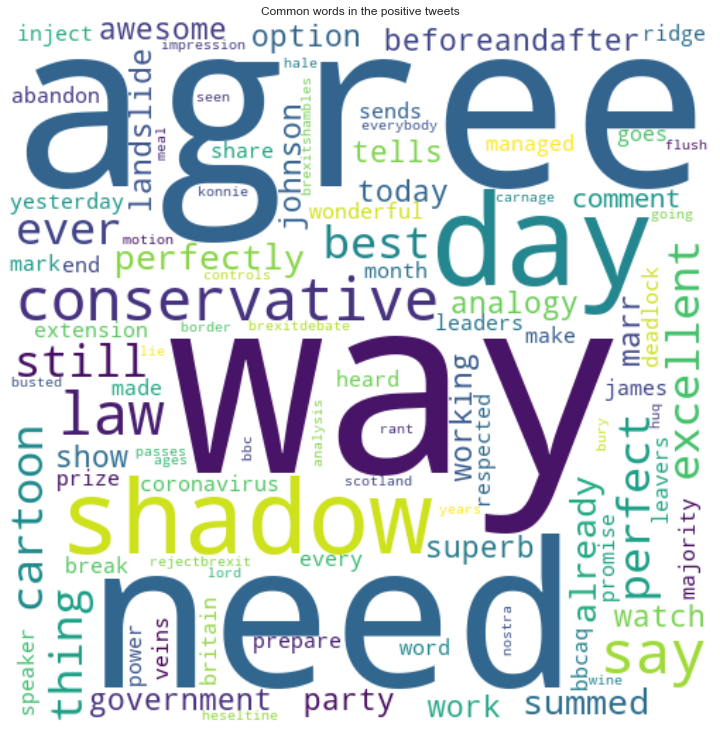

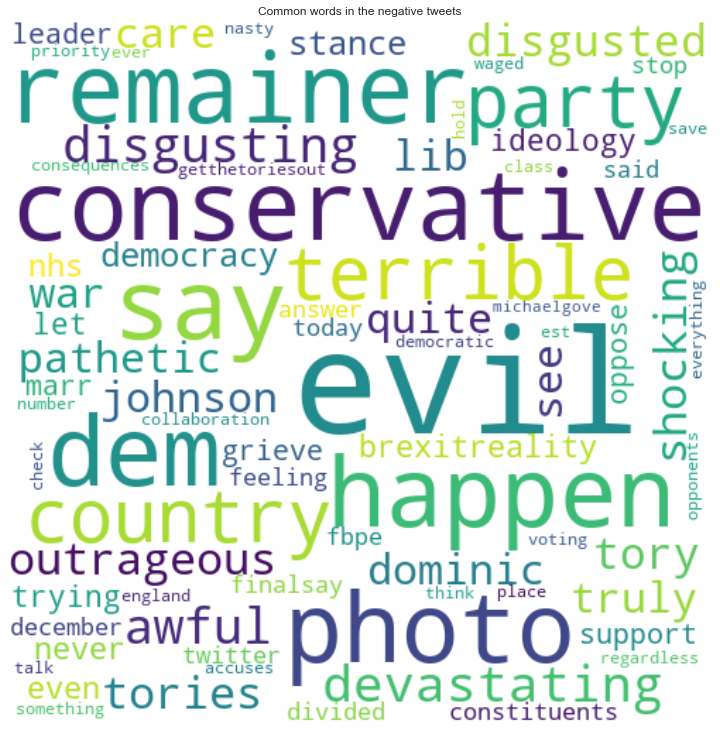

In [31]:
def make_wordcloud(data, label):

    # Initialise a Tf-idf Vectorizer
    polarity_vectorizer = TfidfVectorizer(max_features=5000, stop_words= tfidf_stops)

    # Fit and transform the vectorizer
    tfidf_matrix_polarity = polarity_vectorizer.fit_transform(data["Processed"])

    frequencies_polarity = pd.DataFrame(tfidf_matrix_polarity.sum(axis=0).T,index=polarity_vectorizer.get_feature_names(),columns=['total frequency'])

    # Sort the words by frequency
    frequencies_polarity.sort_values(by='total frequency',ascending=False, inplace=True)

    # Join the indexes
    frequent_words_polarity = " ".join(frequencies_polarity.index)+" "

    # Initialise the word cloud
    wc = WordCloud(width = 500, height = 500, min_font_size = 10, max_words=2000, background_color ='white', stopwords= tfidf_stops)

    # Generate the world clouds for each type of label
    tweets_polarity = wc.generate(frequent_words_polarity)

    # Plot the world cloud                     
    plt.figure(figsize = (10, 10), facecolor = None) 
    plt.imshow(tweets_polarity, interpolation="bilinear") 
    plt.axis("off") 
    plt.title("Common words in the " + label +" tweets")
    plt.tight_layout(pad = 0) 
    plt.show() 

# Create DataFrames for each label
positive_popular_df = tweets_processed.sort_values(by=["Polarity","Favorites","Retweet-Count", ], axis=0, ascending=[False, False, False])[["Content","Retweet-Count","Favorites","Polarity","Processed"]].head(50)
negative_popular_df = tweets_processed.sort_values(by=["Polarity", "Favorites", "Retweet-Count"], axis=0, ascending=[True, False, False])[["Content","Retweet-Count","Favorites","Polarity","Processed"]].head(50)

# Call the function
make_wordcloud(positive_popular_df, "positive")
make_wordcloud(negative_popular_df, "negative")

Positive 

Country
GB    74766
IE     7731
FR     4261
DE     3266
US     2677
      ...  
CI        1
CF        1
AI        1
AD        1
VI        1
Name: Country, Length: 177, dtype: int64

Negative

Country
GB    120567
IE     15547
DE      5959
US      5637
FR      5307
       ...  
FO         1
DJ         1
BQ         1
BI         1
VC         1
Name: Country, Length: 190, dtype: int64


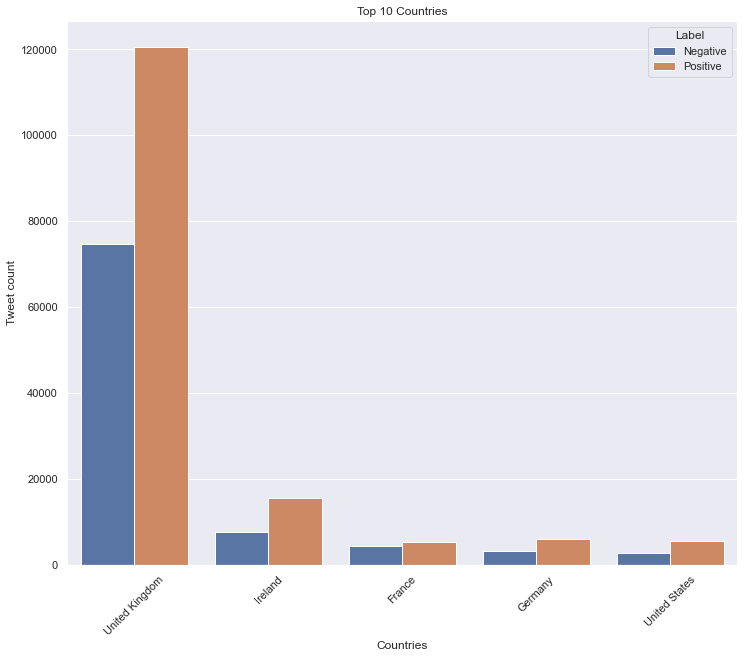

In [32]:
# Get the positive/negative counts by country
positives_by_country = tweets_processed[tweets_processed.Country!='unknown'].groupby("Label")["Country"].value_counts().Negative.sort_values(ascending=False)
negatives_by_country =tweets_processed[tweets_processed.Country!='unknown'].groupby("Label")["Country"].value_counts().Positive.sort_values(ascending=False)

print("Positive \n")
print(positives_by_country)
print("\nNegative\n")
print(negatives_by_country)

# Create a mask for top 1 countries (by tweets count)
mask = tweets_processed["Country"].isin(top_countries.index[:5]).values

# Create a new DataFrame only includes top10 country
top_20df = tweets_processed.iloc[mask,:]

# Visualize the top 20 countries
plt.figure(figsize=(12,10))
sns.countplot(x="Country", hue="Label", data=top_20df, order=top_20df["Country"].value_counts().index)
plt.xlabel("Countries")
locs, labels = plt.xticks()
plt.xticks(locs, country_fullnames[:10])
plt.xticks(rotation=45)
plt.ylabel("Tweet count")
plt.title("Top 10 Countries")
plt.show()

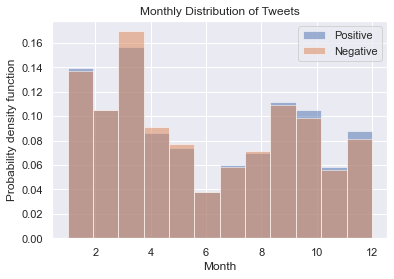

In [33]:
positive = tweets_processed.loc[tweets_processed.Label=="Positive"]["Created At"].dt.month
negative = tweets_processed.loc[tweets_processed.Label=="Negative"]["Created At"].dt.month

plt.hist(positive, alpha=0.5, bins=12, label="Positive", density=True)
plt.hist(negative, alpha=0.5, bins=12, label="Negative", density=True)
plt.xlabel("Month")
plt.ylabel("Probability density function")
plt.title("Monthly Distribution of Tweets")
plt.legend(loc='upper right')
plt.show()

In [25]:
# Save the DataFrame
#tweets_processed.to_csv("Brexit_Tweets_19_20/tweets_sentiments.csv")
#tweets_processed = pd.read_csv('Brexit_Tweets_19_20/tweets_sentiments.csv')

In [34]:
# Encode the labels
le = LabelEncoder()
tweets_processed["Label_enc"] = le.fit_transform(tweets_processed["Label"])

# Display the encoded labels
display(tweets_processed[["Label_enc"]].head())

# Select the features and the target
X = tweets_processed['Processed']
y = tweets_processed["Label_enc"]

,Label_enc
0,1
1,1
2,1
3,1
4,1


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34, stratify=y)

In [36]:
# Create the tf-idf vectorizer
model_vectorizer = TfidfVectorizer()

# First fit the vectorizer with the training set
tfidf_train = vectorizer.fit_transform(X_train)

# Fit the test data with the same vectorizer
tfidf_test = vectorizer.transform(X_test)

# Initialize the Bernoulli Naive Bayes classifier
nb = BernoulliNB()

# Fit the model
nb.fit(tfidf_train, y_train)

# Print the accuracy score
best_accuracy = cross_val_score(nb, tfidf_test, y_test, cv=10, scoring='accuracy').max()
print("Accuracy:",best_accuracy)

Accuracy: 0.8462897183563346


In [37]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [38]:
# Predict the labels
y_pred = nb.predict(tfidf_test)

# Print the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix\n")
print(cm)

# Print the Classification Report Precision = TP/(TP + FP)
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

Confusion Matrix

[[138476  57738]
 [ 22175 296801]]


Classification Report

              precision    recall  f1-score   support

           0       0.86      0.71      0.78    196214
           1       0.84      0.93      0.88    318976

    accuracy                           0.84    515190
   macro avg       0.85      0.82      0.83    515190
weighted avg       0.85      0.84      0.84    515190



In [39]:
cm_plot_labels = ['Positive(1)','Negative(0)']
## TP|FN
## FP|TN

Confusion matrix, without normalization
[[138476  57738]
 [ 22175 296801]]


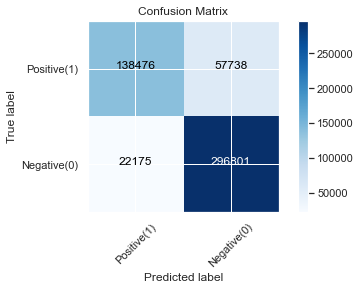

In [40]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')